--- Iniciando Entrenamiento (Double DQN) ---
Episodio: 50/1000, Pasos: 42, Recompensa Promedio (50 ep): 25.58, Epsilon: 0.918
Episodio: 100/1000, Pasos: 36, Recompensa Promedio (50 ep): 26.26, Epsilon: 0.835
Episodio: 150/1000, Pasos: 12, Recompensa Promedio (50 ep): 36.22, Epsilon: 0.752
Episodio: 200/1000, Pasos: 29, Recompensa Promedio (50 ep): 35.22, Epsilon: 0.669
Episodio: 250/1000, Pasos: 13, Recompensa Promedio (50 ep): 47.30, Epsilon: 0.585
Episodio: 300/1000, Pasos: 141, Recompensa Promedio (50 ep): 60.48, Epsilon: 0.502
Episodio: 350/1000, Pasos: 11, Recompensa Promedio (50 ep): 50.34, Epsilon: 0.419
Episodio: 400/1000, Pasos: 240, Recompensa Promedio (50 ep): 139.46, Epsilon: 0.336
Episodio: 450/1000, Pasos: 375, Recompensa Promedio (50 ep): 204.34, Epsilon: 0.252
Episodio: 500/1000, Pasos: 500, Recompensa Promedio (50 ep): 244.14, Epsilon: 0.169
Episodio: 550/1000, Pasos: 143, Recompensa Promedio (50 ep): 246.82, Epsilon: 0.086
Episodio: 600/1000, Pasos: 500, Recompensa Pr

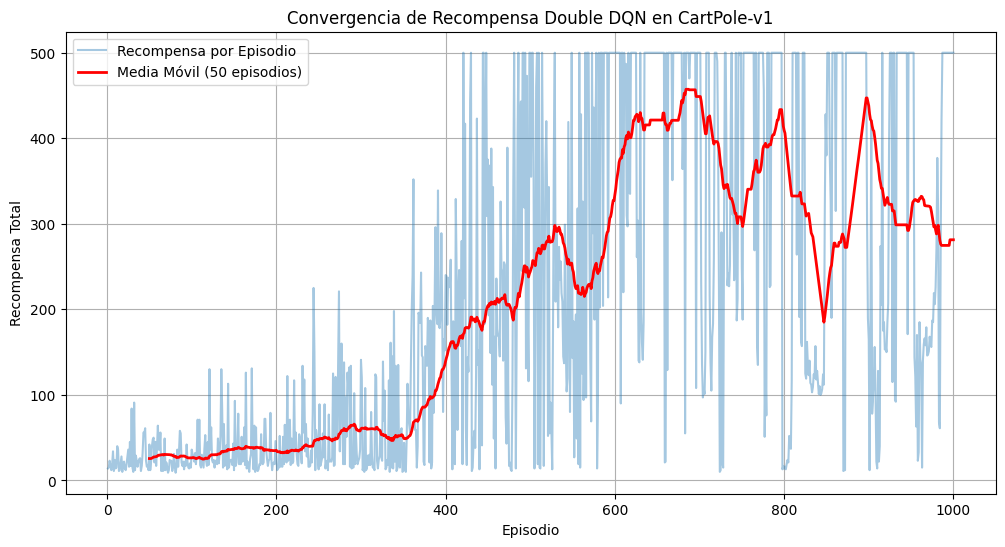


--- Jugando con la política aprendida (Evaluación) ---
Evaluación 1, Recompensa: 500.0, Pasos: 500
Evaluación 2, Recompensa: 500.0, Pasos: 500
Evaluación 3, Recompensa: 500.0, Pasos: 500
Evaluación 4, Recompensa: 500.0, Pasos: 500
Evaluación 5, Recompensa: 500.0, Pasos: 500
Evaluación 6, Recompensa: 500.0, Pasos: 500
Evaluación 7, Recompensa: 500.0, Pasos: 500
Evaluación 8, Recompensa: 500.0, Pasos: 500
Evaluación 9, Recompensa: 500.0, Pasos: 500
Evaluación 10, Recompensa: 500.0, Pasos: 500

Recompensa Promedio en Evaluación (10 episodios): 500.00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import random
import numpy as np
import collections # Para el Replay Buffer (deque)
import matplotlib.pyplot as plt # Para graficar

plt.rcParams.update({
    'figure.facecolor': '#2b2b2b',     # fondo exterior
    'axes.facecolor':   '#2b2b2b',     # fondo del área del gráfico
    'axes.edgecolor':   '#cccccc',     # borde de los ejes
    'axes.labelcolor':  '#cccccc',     # etiquetas de los ejes
    'xtick.color':      '#cccccc',     # color de los números en el eje X
    'ytick.color':      '#cccccc',     # color de los números en el eje Y
    'text.color':       '#cccccc',     # color del título y textos
    'grid.color':       '#444444',     # color de la grilla
})

# --- Hiperparámetros ---
max_episodes = 1000
max_steps_per_episode = 500
learning_rate = 0.001
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.001 # <<<---
epsilon_decay_episodes = 600
buffer_size = 10_000
batch_size = 64
target_update_freq = 100
print_every = 50
smoothing_window = 50

# --- Entorno ---
env = gym.make('CartPole-v1')
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

# --- Red Neuronal (Q-Network) ---
def create_q_network():
    return nn.Sequential(
        nn.Linear(n_observations, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, n_actions)
    )

q_network = create_q_network()
target_network = create_q_network()
target_network.load_state_dict(q_network.state_dict())
target_network.eval()

optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# --- Replay Buffer ---
Transition = collections.namedtuple('Transition',
                                    ('state', 'action', 'reward', 'next_state', 'done'))
replay_buffer = collections.deque(maxlen=buffer_size)

# --- Función para actualizar la Red Objetivo ---
def update_target_network():
    target_network.load_state_dict(q_network.state_dict())

# --- Entrenamiento ---
global_step = 0
epsilon = epsilon_start
episode_rewards_history = []

print("--- Iniciando Entrenamiento (Double DQN) ---")
for episode in range(max_episodes):
    obs, info = env.reset()
    state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
    episode_reward = 0
    episode_steps = 0

    for step in range(max_steps_per_episode):
        global_step += 1
        episode_steps += 1

        if random.random() < epsilon:
            action = torch.tensor([[env.action_space.sample()]], dtype=torch.long)
        else:
            with torch.no_grad():
                q_values = q_network(state)
                action = q_values.max(1)[1].view(1, 1)

        next_obs, reward, terminated, truncated, info = env.step(action.item())
        done = terminated or truncated
        episode_reward += reward

        reward_tensor = torch.tensor([reward], dtype=torch.float32)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_obs, dtype=torch.float32).unsqueeze(0)
        done_tensor = torch.tensor([done], dtype=torch.float32)

        replay_buffer.append(Transition(state, action, reward_tensor, next_state, done_tensor))

        state = next_state

        if len(replay_buffer) >= batch_size:
            transitions = random.sample(replay_buffer, batch_size)
            batch = Transition(*zip(*transitions))

            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            state_action_values = q_network(state_batch).gather(1, action_batch).squeeze(1)

            # --- INICIO DE LA MODIFICACIÓN DOUBLE DQN ---
            next_state_values = torch.zeros(batch_size)
            with torch.no_grad():
                # 1. Seleccionar la MEJOR acción para s' usando la red ONLINE
                online_next_q_values = q_network(non_final_next_states)
                online_best_next_actions = online_next_q_values.max(1)[1].unsqueeze(1) # Indices (argmax)

                # 2. Evaluar el valor Q de ESA acción seleccionada usando la red TARGET
                target_next_q_values = target_network(non_final_next_states)
                # Usamos gather para obtener Q_target(s', argmax_a' Q_online(s', a'))
                selected_target_next_q_values = target_next_q_values.gather(1, online_best_next_actions).squeeze(1)

                # Asignar los valores calculados con DDQN a las entradas correspondientes
                next_state_values[non_final_mask] = selected_target_next_q_values
            # --- FIN DE LA MODIFICACIÓN DOUBLE DQN ---

            expected_state_action_values = reward_batch + (gamma * next_state_values)

            loss = loss_fn(state_action_values, expected_state_action_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if global_step % target_update_freq == 0:
            update_target_network()

        if done:
            break

    episode_rewards_history.append(episode_reward)
    epsilon = max(epsilon_end, epsilon_start - (episode / epsilon_decay_episodes) * (epsilon_start - epsilon_end))

    if (episode + 1) % print_every == 0:
        avg_reward = np.mean(episode_rewards_history[-print_every:])
        print(f'Episodio: {episode + 1}/{max_episodes}, Pasos: {episode_steps}, Recompensa Promedio ({print_every} ep): {avg_reward:.2f}, Epsilon: {epsilon:.3f}')

print("--- Entrenamiento Finalizado ---")

# --- Graficar Curva de Convergencia ---
print("\n--- Generando Gráfico de Convergencia ---")
plt.figure(figsize=(12, 6))
plt.plot(range(1, max_episodes + 1), episode_rewards_history, label='Recompensa por Episodio', alpha=0.4)
if len(episode_rewards_history) >= smoothing_window:
    rewards_smoothed = np.convolve(episode_rewards_history, np.ones(smoothing_window)/smoothing_window, mode='valid')
    plt.plot(range(smoothing_window, max_episodes + 1), rewards_smoothed, label=f'Media Móvil ({smoothing_window} episodios)', color='red', linewidth=2)
plt.xlabel("Episodio")
plt.ylabel("Recompensa Total")
plt.title("Convergencia de Recompensa Double DQN en CartPole-v1") # <-- Título actualizado
plt.legend()
plt.grid(True)
plt.show()

# --- Test (Evaluación SIN RENDERIZADO) ---
print("\n--- prueba con la política aprendida (Evaluación) ---")
eval_env = gym.make('CartPole-v1')
total_eval_reward = 0
num_eval_episodes = 10

for i in range(num_eval_episodes):
    obs, info = eval_env.reset()
    state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
    done = False
    episode_eval_reward = 0
    episode_steps = 0
    while not done and episode_steps < max_steps_per_episode:
        with torch.no_grad():
            q_values = q_network(state)
            action = q_values.max(1)[1].view(1, 1)

        obs, reward, terminated, truncated, info = eval_env.step(action.item())
        done = terminated or truncated
        episode_eval_reward += reward
        episode_steps += 1

        if not done:
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

    print(f'Evaluación {i+1}, Recompensa: {episode_eval_reward}, Pasos: {episode_steps}')
    total_eval_reward += episode_eval_reward

print(f'\nRecompensa Promedio en Evaluación ({num_eval_episodes} episodios): {total_eval_reward / num_eval_episodes:.2f}')
eval_env.close()
env.close()